In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import string
import nltk
import numpy as np
import tensorflow as tf
import pickle 

from tqdm import tqdm
from random import choices
from tensorflow.keras import layers, models, losses, metrics, initializers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

from preprocessing import *

In [2]:
df = pd.read_csv("data/emails.csv")
X = df.Text
y = df.Spam
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Preprocessing
- Get the vocabulary of the training set
- Create functions to convert integers to respective words and vice-versa

In [3]:
all_words, emails = process_documents(X_train)
all_words = {key:value+2 for key, value in all_words.items()}
all_words["<PAD>"]=0
all_words["[UNK]"]=1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4582/4582 [00:46<00:00, 98.59it/s]


In [4]:
rev_words = {item[1]:item[0] for item in all_words.items()}

In [5]:
M = len(all_words)
M

30444

In [6]:
def word2int(word):
    return all_words[word]

def int2word(idx):
    return rev_words[idx]

- Set each sentence into a tabular format of accepted indexes

In [7]:
emails = get_indexed_documents(X_train, all_words)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4582/4582 [00:47<00:00, 96.90it/s]


In [8]:
MAX_SQ_LEN = get_max_length(emails)
MAX_SQ_LEN

4109

In [9]:
emails = np.array(apply_padding(emails, MAX_SQ_LEN))

In [10]:
emails.shape

(4582, 4109)

- Convert validation set to the same format

In [11]:
test_set_emails = get_indexed_documents(X_test, all_words)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1146/1146 [00:11<00:00, 98.52it/s]


In [13]:
get_max_length(test_set_emails)

1802

In [14]:
test_set_emails = np.array(apply_padding(test_set_emails, MAX_SQ_LEN))
test_set_emails.shape

(1146, 4109)

## Load Embedding Representation

In [15]:
embed_vectors=np.load("./data/glove_vectors.npy")

- Need to add Vector for *Padding* and *Unkown* characters

In [16]:
embed_vectors = np.concatenate((
    np.zeros(shape=(2, embed_vectors.shape[1])),
    embed_vectors
))

In [17]:
len(embed_vectors)

30444

## Model Creation

In [25]:
cnn = models.Sequential([
    layers.InputLayer(input_shape=MAX_SQ_LEN),
    layers.Embedding(
        input_dim=M,
        output_dim=embed_vectors.shape[1],
        embeddings_initializer=initializers.Constant(embed_vectors),
        trainable=False
    ),
    layers.Conv1D(
        filters=128,
        kernel_size=5,
        activation="relu"
    ),
    layers.MaxPool1D(5),
    layers.Conv1D(
        filters=64,
        kernel_size=5,
        activation="relu"
    ),
    layers.MaxPool1D(5),
    layers.Conv1D(
        filters=32,
        kernel_size=5,
        activation="relu"
    ),
    layers.MaxPool1D(3),
    layers.Conv1D(
        filters=16,
        kernel_size=5,
        activation="relu"
    ),
    layers.GlobalMaxPool1D(),
    layers.Dense(
        units=1,
        activation="sigmoid"
    )
    
])

In [26]:
cnn.compile("adam", loss="binary_crossentropy", metrics=[metrics.Recall()])

In [27]:
cnn.fit(emails, y_train, epochs=5, batch_size=16, validation_data=(test_set_emails, y_test))

Epoch 1/5
287/287 [==============================] - 12s 38ms/step - loss: 0.2009 - recall_1: 0.6992 - val_loss: 0.0949 - val_recall_1: 0.9579
Epoch 2/5
287/287 [==============================] - 11s 37ms/step - loss: 0.0669 - recall_1: 0.9557 - val_loss: 0.0849 - val_recall_1: 0.9502
Epoch 3/5
287/287 [==============================] - 11s 38ms/step - loss: 0.0411 - recall_1: 0.9783 - val_loss: 0.0687 - val_recall_1: 0.9617
Epoch 4/5
287/287 [==============================] - 11s 38ms/step - loss: 0.0231 - recall_1: 0.9864 - val_loss: 0.0859 - val_recall_1: 0.9770
Epoch 5/5
287/287 [==============================] - 11s 40ms/step - loss: 0.0227 - recall_1: 0.9810 - val_loss: 0.0936 - val_recall_1: 0.9923


In [28]:
preds = cnn.predict(test_set_emails)

36/36 [==============================] - 2s 27ms/step


In [31]:
(preds>0.5)*1

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [34]:
print(classification_report(y_test, (preds>0.5)*1 ))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       885
           1       0.89      0.99      0.94       261

    accuracy                           0.97      1146
   macro avg       0.94      0.98      0.96      1146
weighted avg       0.97      0.97      0.97      1146



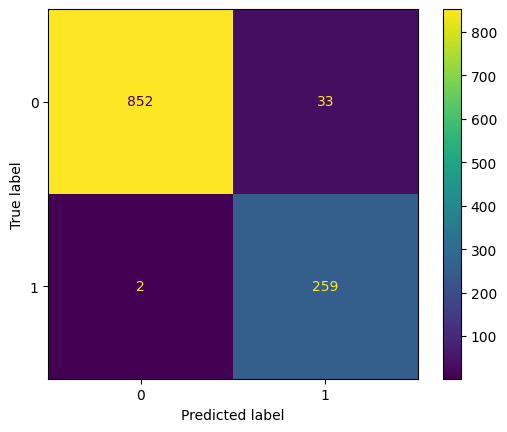

In [35]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test, (preds>0.5)*1)
).plot()